In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [0]:
!mkdir MNIST_Fashion
! cp *.gz MNIST_FASSHION/
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_Fashion/")

In [0]:
#Training parameters

learning_rate = 0.0002
batch_size = 128
epochs = 100000

#NEtwork parameters
image_dim = 784      #Image size is 28x28
gen_hidd_dim = 256
disc_hidd_dim = 256
z_noise_dim = 100 #Input noise data point

def xavier_init(shape):
  return tf.random_normal(shape = shape, stddev = 1./tf.sqrt(shape[0]/2.0))

In [0]:
weights = { "disc_H" : tf.Variable(xavier_init([image_dim, disc_hidd_dim])),
           "disc_final" : tf.Variable(xavier_init([disc_hidd_dim, 1])),
           "gen_H" : tf.Variable(xavier_init([z_noise_dim, gen_hidd_dim])),
           "gen_final": tf.Variable(xavier_init([gen_hidd_dim, image_dim])),
}

bias = { "disc_H" : tf.Variable(xavier_init([disc_hidd_dim])),
           "disc_final" : tf.Variable(xavier_init([1])),
           "gen_H" : tf.Variable(xavier_init([gen_hidd_dim])),
           "gen_final": tf.Variable(xavier_init([image_dim])),
}

In [0]:
#Define Discrimnator function
def Discriminator(x):
  hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, weights["disc_H"]), bias["disc_H"]))
  final_layer = tf.add(tf.matmul(hidden_layer, weights["disc_final"]), bias["disc_final"])
  disc_output = tf.nn.sigmoid(final_layer)
  return final_layer, disc_output

#Define generator network
def Generator(x):
  hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, weights["gen_H"]), bias["gen_H"]))
  final_layer = tf.add(tf.matmul(hidden_layer, weights["gen_final"]), bias["gen_final"])
  gen_output = tf.nn.sigmoid(final_layer)
  return gen_output

#Define the placeholders for External input
Z_input = tf.placeholder(tf.float32, shape = [None, z_noise_dim], name = "input_noise")
X_input = tf.placeholder(tf.float32, shape = [None, image_dim], name = "real_input")

#Building the Generator Network
with tf.name_scope("Generator") as scope:
  output_Gen = Generator(Z_input)
  
#Building the Discriminator Network
with tf.name_scope("Discriminator") as scope:
  real_output1_Disc, real_output_Disc = Discriminator(X_input) #Implements D(x)
  fake_output1_Disc, fake_output_Disc = Discriminator(output_Gen) #Implements D(G(x))   #two outputs one before the sigmoid and one after
  

In [0]:
#Defining loss function for optimizaiton via back propogation
with tf.name_scope("Discriminator_Loss") as scope:                                                                     # '-' is used below to because we need to maximize the Discriminator function
  Discriminator_Loss = -tf.reduce_mean(tf.log(real_output_Disc +0.0001) + tf.log(1.- fake_output_Disc + 0.0001))      #0.0001 added as small delta to avoid blowing of log term, function is  max D {log(D(x)+log(1-D(G(x)))}
  
with tf.name_scope("Generator_Loss") as scope:                                           #generator cannot learn from "min G log(1-D(G(x)))" because of vanishing gradient, so we use "max G log(D(G(x)))"
  Generator_Loss = -tf.reduce_mean(tf.log(fake_output_Disc + 0.0001))  #we use '-' because we want to take maximization.

 #TensorBoard Summary
Disc_loss_total = tf.summary.scalar("Disc_Total_loss", Discriminator_Loss)
Gen_loss_total = tf.summary.scalar("Gen_Loss", Generator_Loss)

In [0]:
#Defining the variables
Generator_var = [weights["gen_H"], weights["gen_final"], bias["gen_H"], bias["gen_final"]]
Discriminator_var = [weights["disc_H"], weights["disc_final"], bias["disc_H"], bias["disc_final"]]

#Define the optimizer
with tf.name_scope("Optimizer_Discriminator") as scope:
  Discriminator_optimize = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(Generator_Loss, var_list = Discriminator_var)
  
with tf.name_scope("Optimizer_Generator") as scope:
  Generator_optimize = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(Generator_Loss, var_list = Generator_var)
                                   

In [20]:
#Initialize the variables
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)
writer = tf.summary.FileWriter("./log", sess.graph)

for epoch in range(epochs):
  X_batch, _ = mnist.train.next_batch(batch_size)
  
  #Generate noise to feed the discriminator
  Z_noise = np.random.uniform(-1.,1., size = [batch_size, z_noise_dim])
  _, Disc_loss_epoch = sess.run([Discriminator_optimize, Discriminator_Loss], feed_dict = {X_input:X_batch, Z_input:Z_noise})
  _, Gen_loss_epoch = sess.run([Generator_optimize, Generator_Loss], feed_dict = {Z_input : Z_noise})
  
  #Running the discriminator summary
  summary_Disc_Loss = sess.run(Disc_loss_total, feed_dict = {X_input:X_batch ,Z_input:Z_noise})
  #Adding the discriminator summary
  writer.add_summary(summary_Disc_Loss, epoch)
  
  #Running the Generator summary
  summary_Gen_Loss = sess.run(Gen_loss_total, feed_dict = {Z_input:Z_noise})
  #Adding the Generator summary
  writer.add_summary(summary_Gen_Loss, epoch)
  
  if epoch % 2000 == 0:
    print("StepsL{0} : Generator Loss:{1}, Discriminator Loss : {2}".format(epoch,Gen_loss_epoch, Disc_loss_epoch))

StepsL0 : Generator Loss:1.0947599411010742, Discriminator Loss : 1.1381642818450928
StepsL2000 : Generator Loss:-0.00010000880138250068, Discriminator Loss : 9.263042449951172
StepsL4000 : Generator Loss:-0.00010001159535022452, Discriminator Loss : 9.250102996826172
StepsL6000 : Generator Loss:-0.00010001159535022452, Discriminator Loss : 9.262618064880371
StepsL8000 : Generator Loss:-0.00010001159535022452, Discriminator Loss : 9.255277633666992
StepsL10000 : Generator Loss:-0.00010001159535022452, Discriminator Loss : 9.254132270812988
StepsL12000 : Generator Loss:-0.00010001159535022452, Discriminator Loss : 9.251890182495117
StepsL14000 : Generator Loss:-0.00010001159535022452, Discriminator Loss : 9.260146141052246
StepsL16000 : Generator Loss:-0.00010001159535022452, Discriminator Loss : 9.257718086242676
StepsL18000 : Generator Loss:-0.00010001159535022452, Discriminator Loss : 9.252089500427246
StepsL20000 : Generator Loss:-0.00010001159535022452, Discriminator Loss : 9.24450

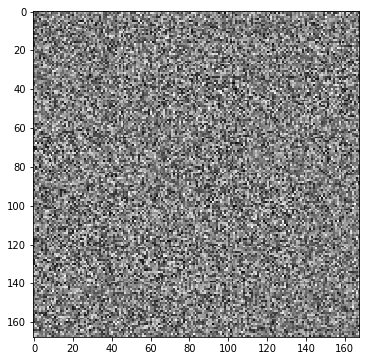

In [23]:
#Testing
#Generate images from noise, using the generator network
n = 6
canvas = np.empty((28 * n, 28 * n))
for i in range(n):
  #Noise input
  Z_noise = np.random.uniform(-1.,1., size = [batch_size, z_noise_dim])
  #Generate image from noise
  g = sess.run(output_Gen, feed_dict={Z_input: Z_noise})
  #Revers colours for better display
  g = -1* (g-1)
  for j in range(n):
    #Draw the generate digits
    canvas[i * 28:(i + 1) * 28, j * 28: (j + 1) * 28] = g[j].reshape([28, 28])
    
plt.figure(figsize=(n,n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()